In [6]:
#Imports
from typing import get_type_hints
from matplotlib import lines
from numpy.lib.function_base import append
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import ta
import math
from finta import TA
import pytz
import eikon as ek
from threading import Event
import xlwt
import xlsxwriter


.MERV


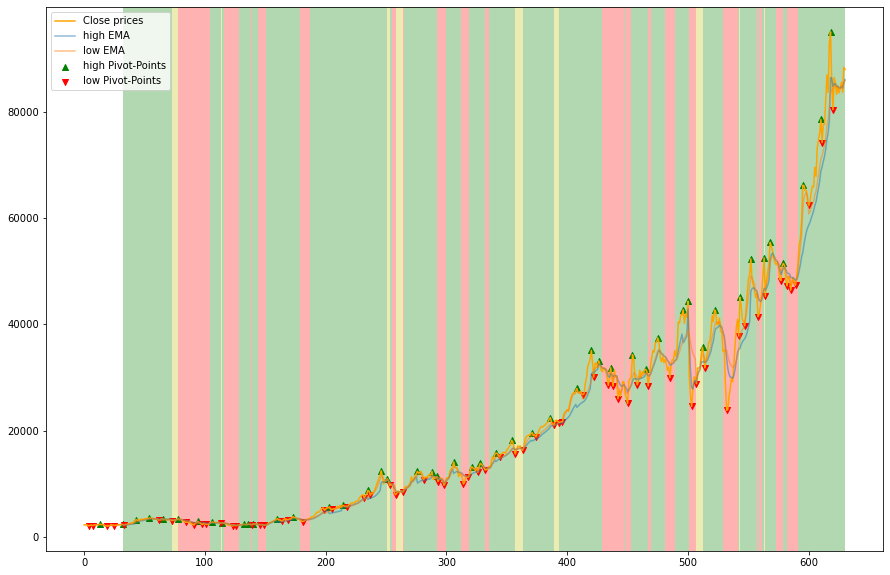

.AFLI


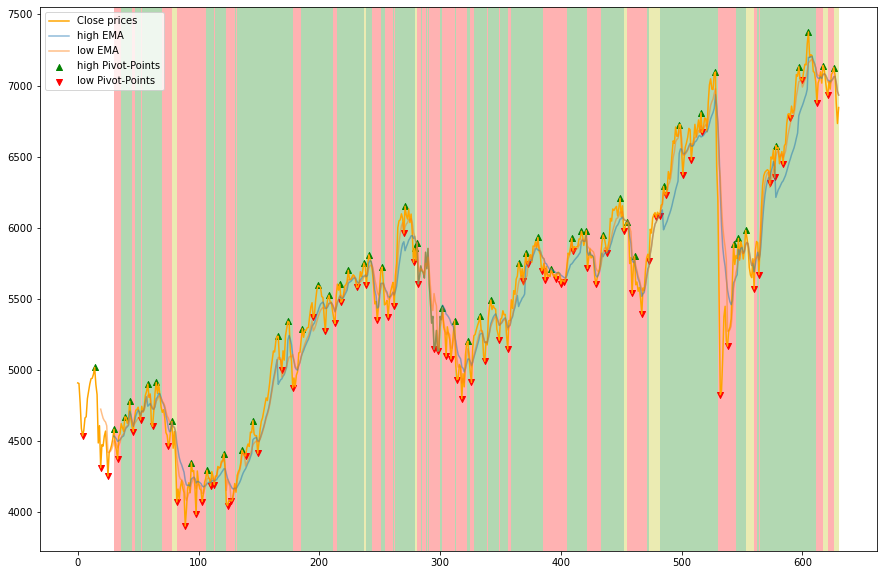

.BVSP


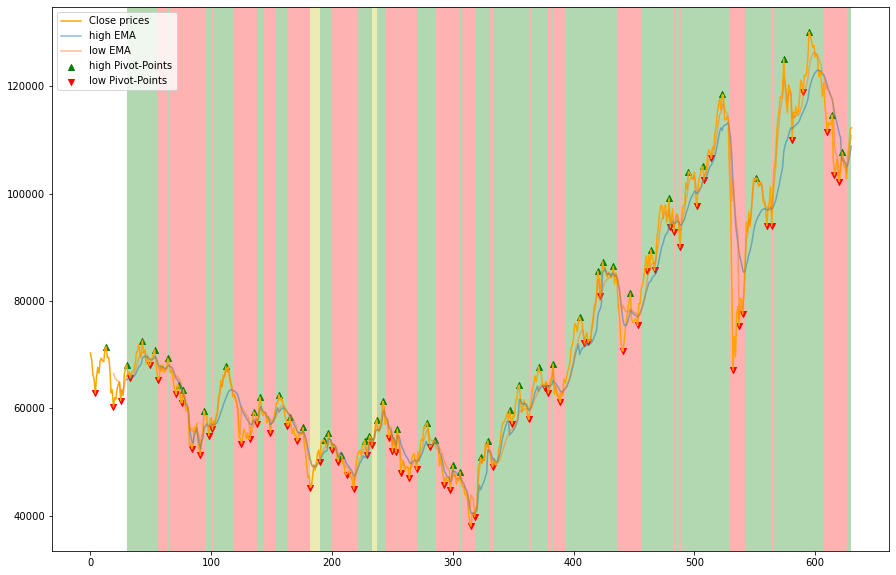

.SPTSE


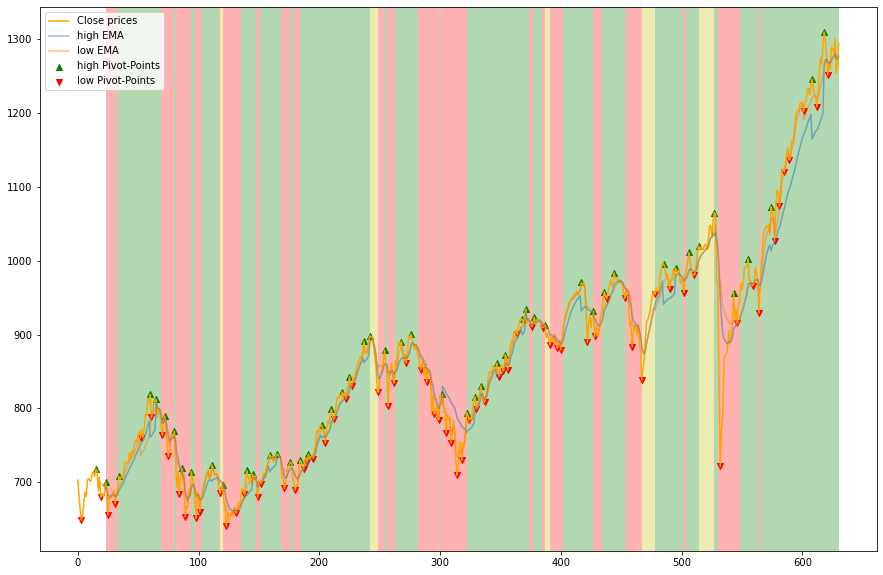

.HSI


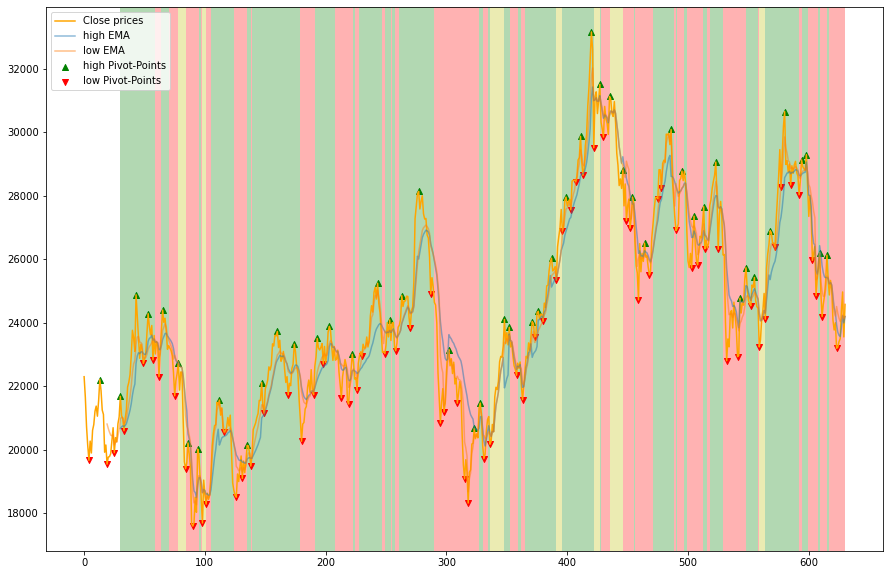

.STOXX50E


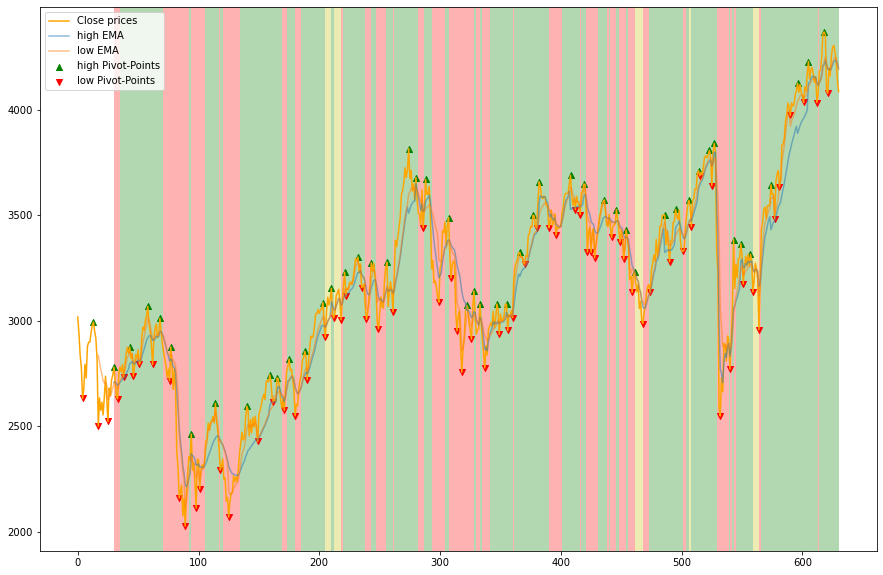

.FCHI


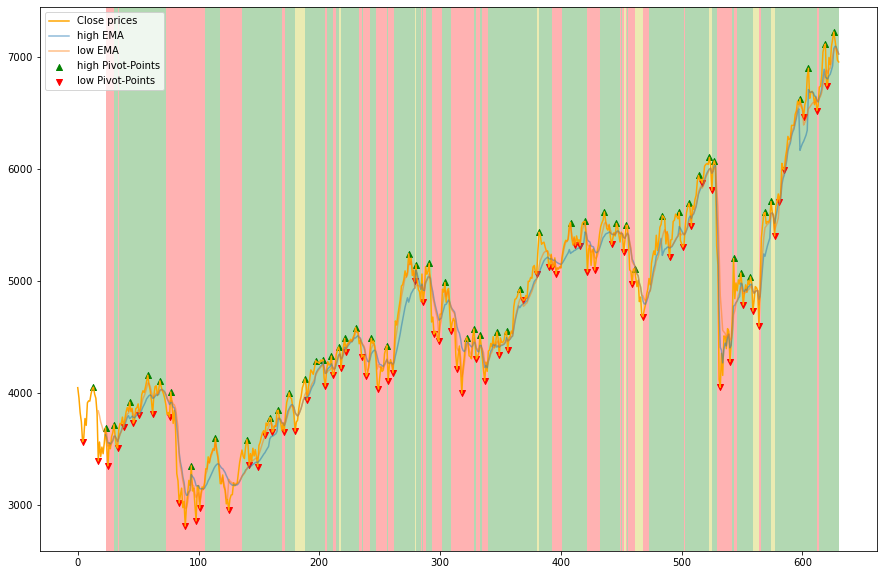

.GDAXIP


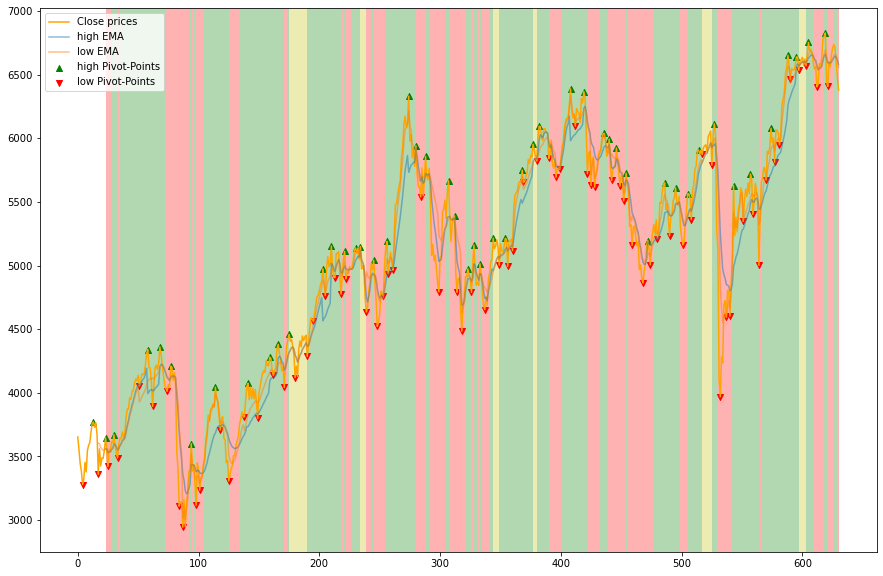

.BSESN


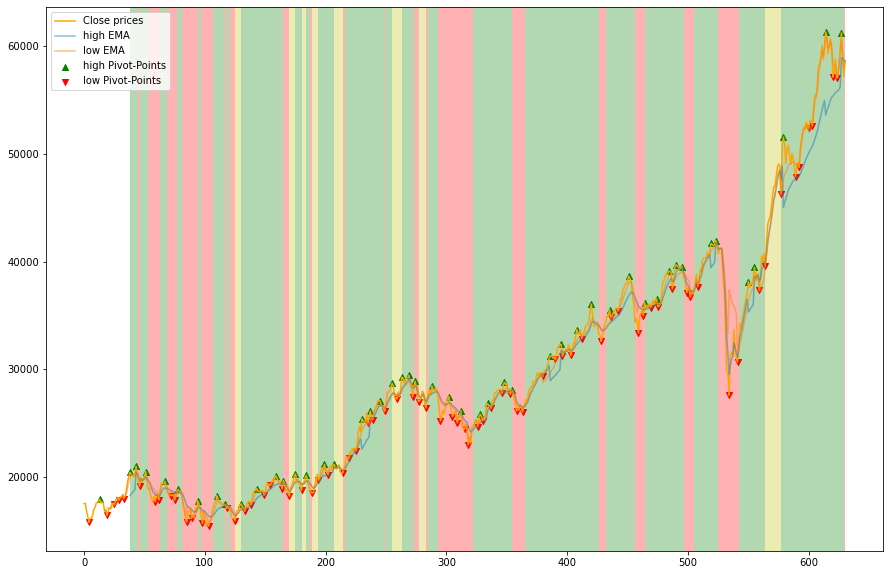

.JKSE


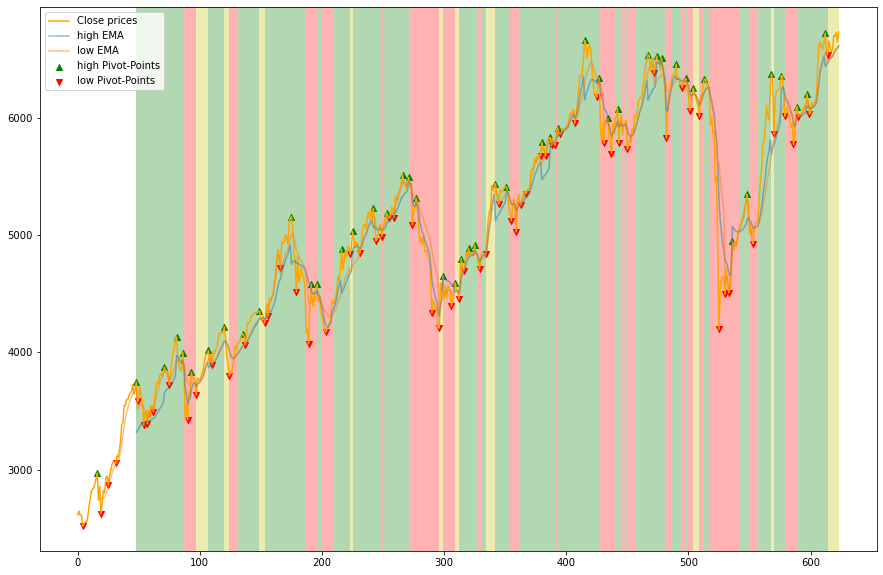

.MXX


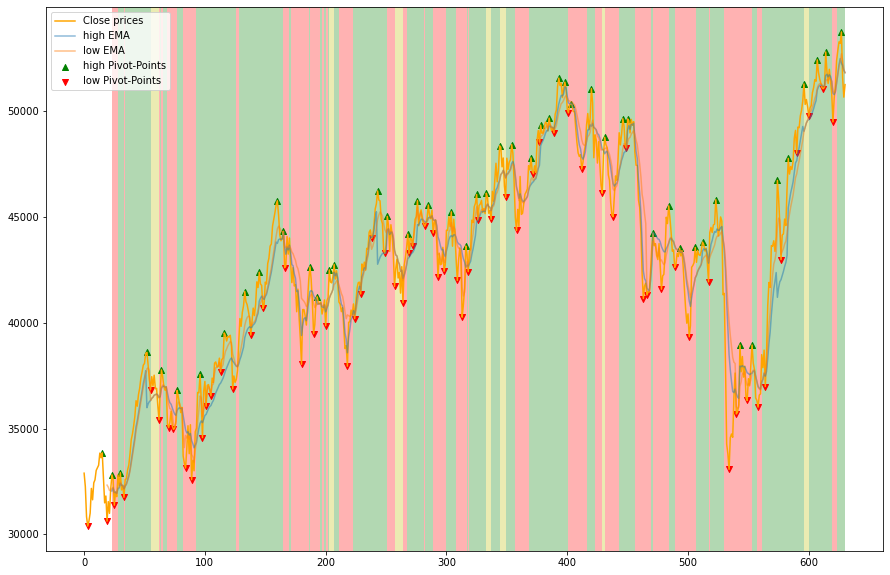

.IRTS


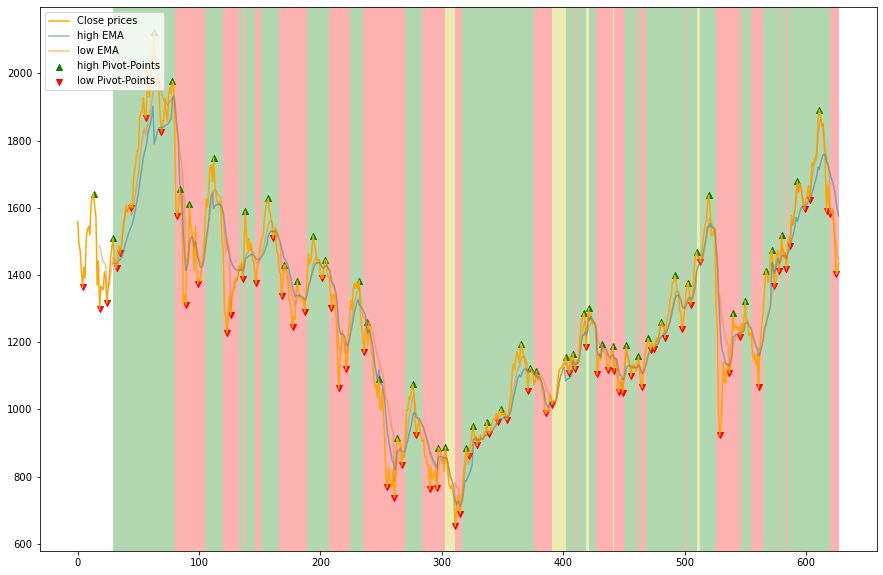

.KS11


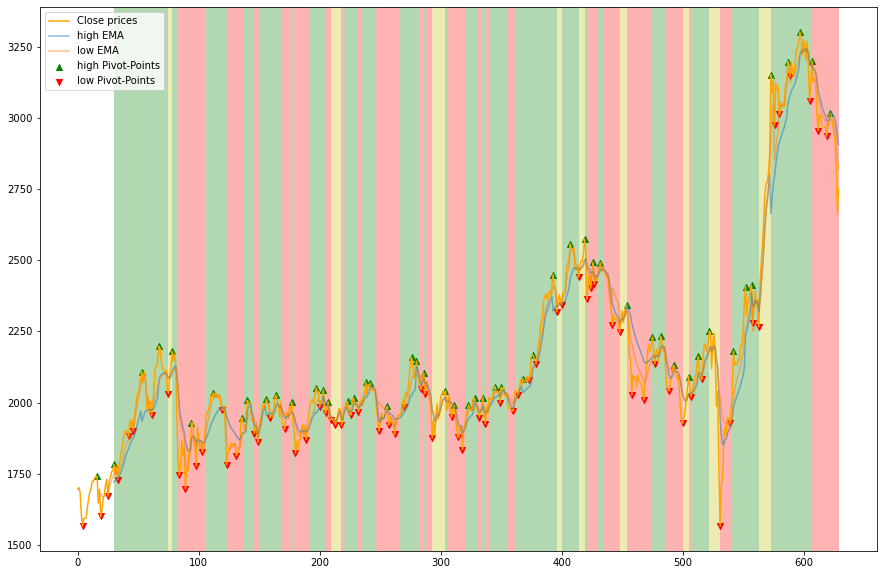

.XU100


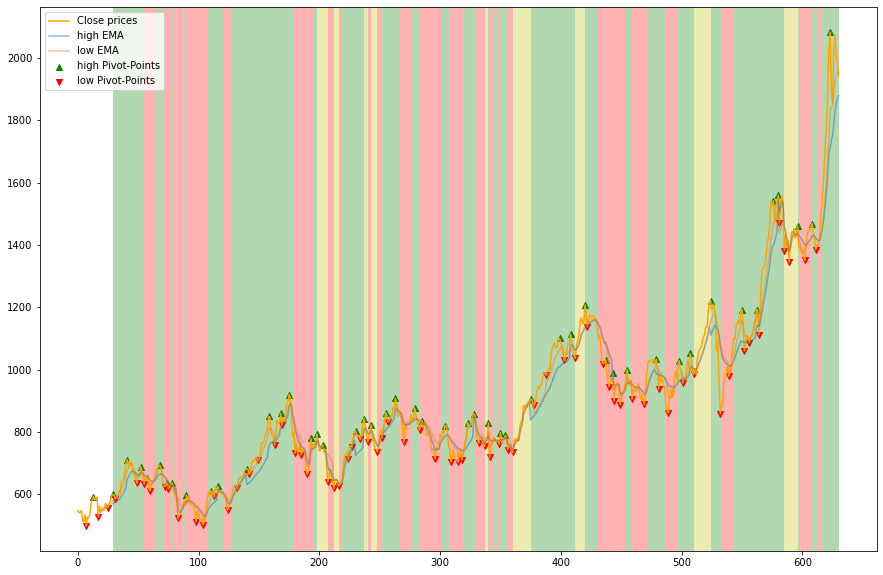

.FTSE


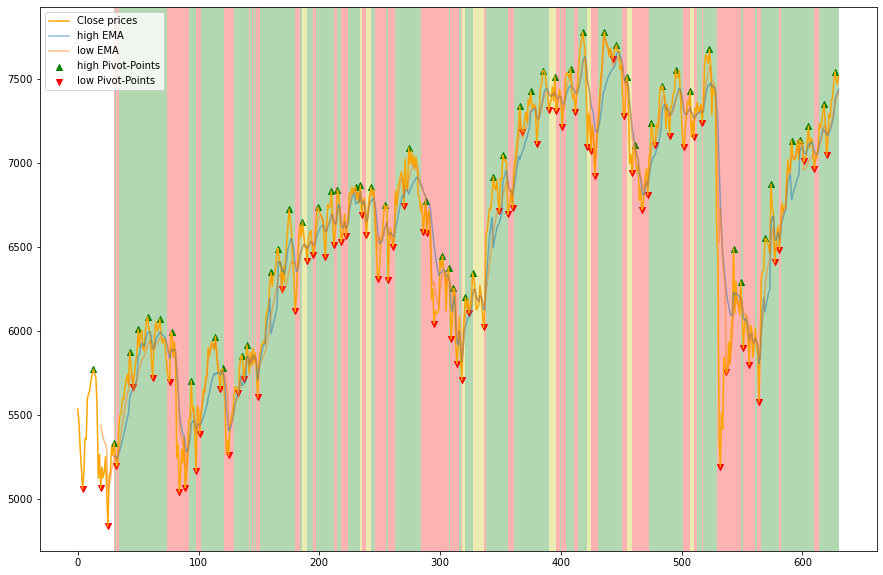

.SPX


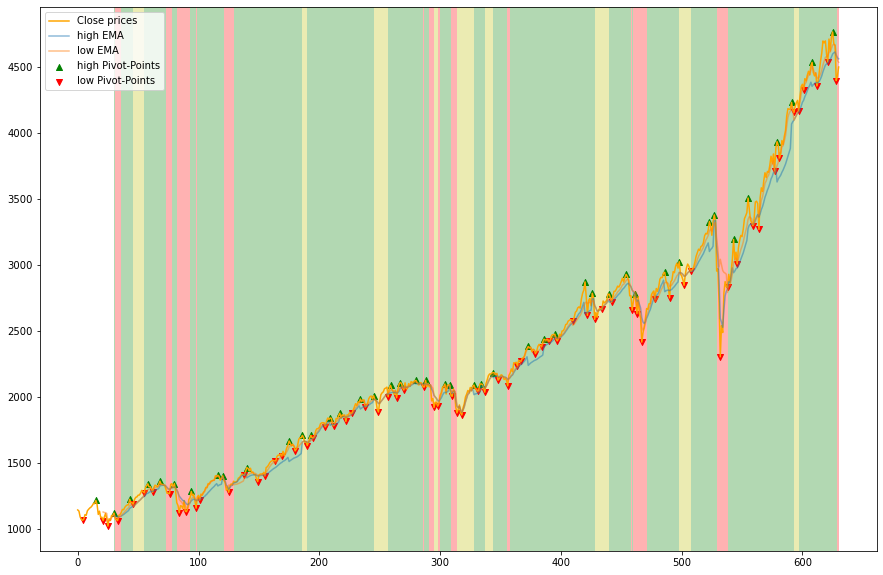

.IXIC


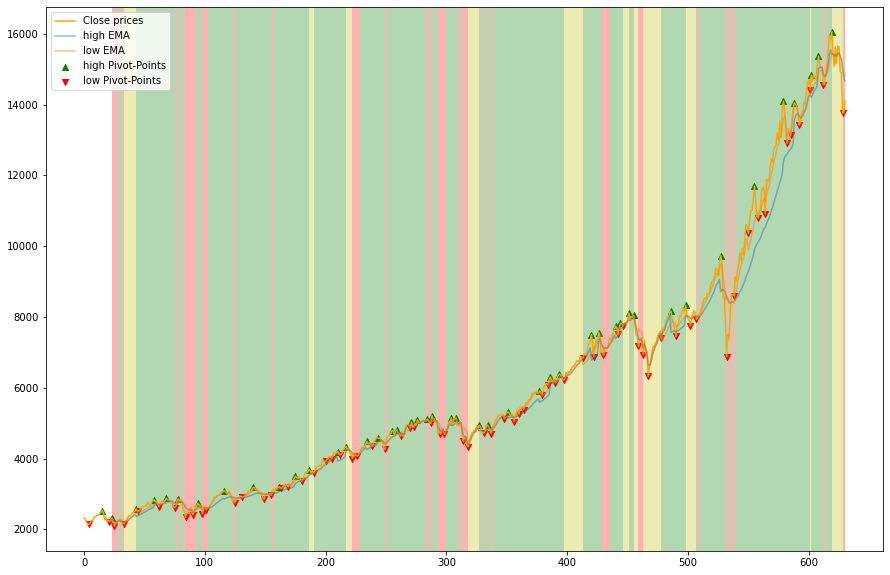

.RUT


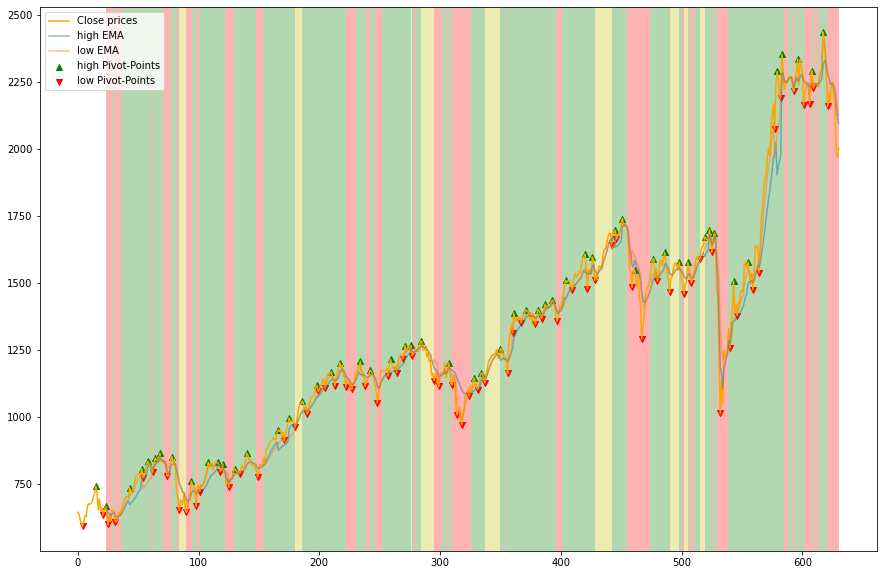

Letzten 20 Signale:
            .MERV  .AFLI  .BVSP  .SPTSE  .HSI  .STOXX50E  .FCHI  .GDAXIP  \
dates                                                                      
2021-09-24    1.0   -1.0   -1.0     1.0  -1.0        1.0    1.0     -1.0   
2021-10-01    1.0   -1.0   -1.0     1.0  -1.0        1.0   -1.0     -1.0   
2021-10-08    1.0   -1.0   -1.0     1.0  -1.0       -1.0   -1.0     -1.0   
2021-10-15    1.0   -1.0   -1.0     1.0  -1.0        1.0    1.0     -1.0   
2021-10-22    1.0   -1.0   -1.0     1.0   1.0        1.0    1.0     -1.0   
2021-10-29    1.0   -1.0   -1.0     1.0   1.0        1.0    1.0     -1.0   
2021-11-05    1.0    0.0   -1.0     1.0  -1.0        1.0    1.0      1.0   
2021-11-12    1.0    0.0   -1.0     1.0  -1.0        1.0    1.0      1.0   
2021-11-19    1.0    0.0   -1.0     1.0  -1.0        1.0    1.0      1.0   
2021-11-26    1.0    0.0   -1.0     1.0  -1.0        1.0    1.0      1.0   
2021-12-03    1.0   -1.0   -1.0     1.0  -1.0        1.0    1.0     

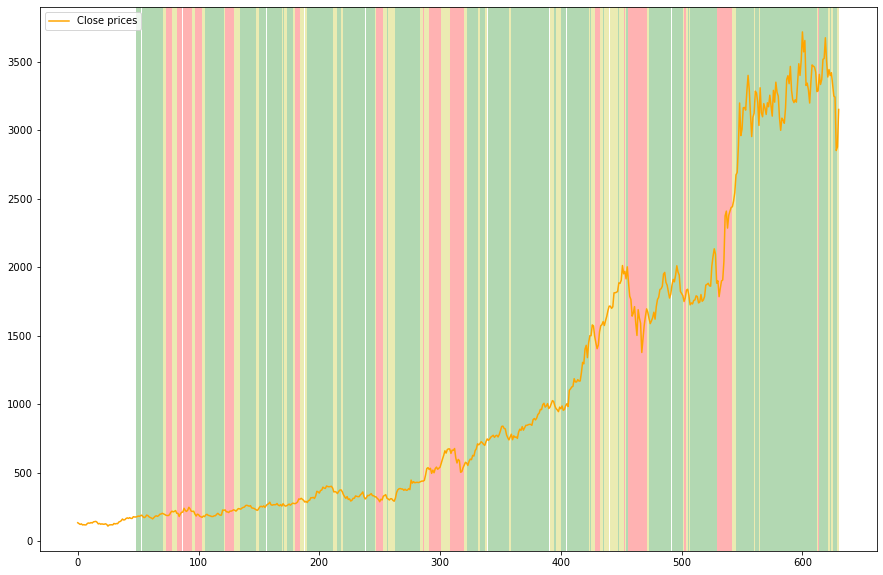

In [7]:
#Die Klasse Backtester beinhaltet alle Funktionen die man für die Börsenampel braucht
class Backtester():

    def __init__(self):#Die init Funktion
        #In dieser Funktion werden erst alle Variablen initalisiert und dann werden die Funktionen aufgerufen, die man für die Arbeit benötigt.
        self.names = [".MERV",".AFLI",".BVSP",".SPTSE",".HSI",".STOXX50E",".FCHI",".GDAXIP",".BSESN",".JKSE",".MXX",".IRTS",".KS11",".XU100",".FTSE",".SPX",".IXIC",".RUT"]#Die Symbole von allen Indizes die heruntergeladen werden sollen
        self.start_date = "2010-01-08"#Das Anfangsdatum, ab dem Marktdaten heruntergeladen werden.
        self.end_date = datetime.now()#Das Enddatum, bis zu dem Marktdaten heruntergeladen werden. Hier ist das Enddatum der heutige Tag.
        
        #Das password für Datastream(Eikon) holen
        password_file = open(r"C:\Users\jensb\Documents\Praktikum\Stock_Prediction\03-07-2021\passwords.txt", "r")
        eikon_password = password_file.readline()
        
        #Die erste Funktion, mit dieser holle ich mir alle Marktdaten von allen oben gelisteten Indizes. Dann werden auch gleich die Signale für alle Indexe auf diese Marktdaten gebildet und zurückgegeben.
        allSignals = self.loadFromEikon(password=eikon_password)
        
        print("Letzten 20 Signale:")
        print(allSignals.tail(20))
        
        #Nachdem man alle Signale hat, kann man diese noch verschieden anzeigen und noch mehr mit diesen experimentieren

        #self.plotTable(allSignals, 20)
        #self.createExcel(allSignals, 200)
        #self.SignalsOnMSCI(allSignals)
        #self.plotTable(allSignals)
        #self.plotData(highs, lows, highPeriods, lowPeriods, highEMAs, lowEMAs, signals)
        self.plotGraph2(allSignals, "AMZN.O")
        
    def loadFromEikon(self, password):
        #In dieser Funktion werden die Marktdaten von allen der gegebenen Indizes von Datastream(Eikon) heruntergeladen
        ek.set_app_key(str(password))#Das Passwort für Eikon/Datastream
        ek.set_timeout(30)#Wie lange eine Anfrage dauern soll, bis sie angehalten wird und die ganze Anfrage neugestartet wird
        allSignals = pd.DataFrame()#Noch leeres DataFrame, das am Ende die Signale aller Indizes enthält
        for i in range(len(self.names)):#Schleife, die alle Symbole der Indizes nacheinander aufruft 
            timer = Event()#Event, das man braucht um eine bestimmte Zeit zu warten. Hier eine Sekunde
            print(self.names[i])#Das Symbol des Indexes anzeigen, von dem man gerade die Marktdaten herunterlädt
            while True:#Unendliche Schleife, die sich immer wiederholt, bis man sie abbricht.
                try:
                    dataOfCurrentCompanie = ek.get_timeseries(self.names[i], interval="weekly", fields=["close"], start_date=self.start_date, end_date=self.end_date)#Herunterladen der Marktdaten des Indexes, das gerade dran ist
                    break#Abbrechen der Unendlichschleife, wenn die gewünschten Daten heruntergeladen wurden
                except ek.EikonError as e:
                    if e.code == 500 or e.code == 2504:#Bei bestimmten Fehlermeldungen ist es Sinnvol kurz das Programm anzuhalten und zu warten
                        timer.wait(1)#Eine Sekunde warten
                    else:
                        print(e.code)#Bei anderen Fehlermeldungen wird die Fehlermeldung angezeigt und die Unendlichschleife wird abgebrochen
                        break
            #Hier wird die Form der gerade heruntergeladenen Marktdaten eines Indexes nur umgewandelt. Mit den Marktdaten passiert nichts,sie werden nur in eine andere Form gebracht.
            dataOfCurrentCompanie = dataOfCurrentCompanie.reset_index().reset_index()
            dataOfCurrentCompanie = dataOfCurrentCompanie.rename(columns={"CLOSE":"close", "Date":"date"})
            close = dataOfCurrentCompanie["close"].to_list()

            #Auf die Marktdaten des Indexes wird die Hauptstrategie angewendet, die die gewünschten Signale zurück gibt.
            dates, indicator = self.mainStrategy(close, dataOfCurrentCompanie, eikonConnected=True, plotting=True)

            #Hier werden die Signale dieses einen Indexes zu dem DataFrame, das am Ende alle Signale enthält hinzugefügt.
            adding = pd.DataFrame()
            adding["dates"] = dates
            adding[self.names[i]] = indicator
            adding = adding.set_index(adding["dates"])
            adding = adding.drop(columns={"dates"})
            allSignals = pd.concat([allSignals, adding], axis=1)
            resultsNumbers = []
            resultsColors = []
        
        #Die Signale werden zusammen addiert und für jeden Zeitschritt wird ein Hauptsignal ermittelt.
        for i in range(len(allSignals)):
            counter = 0
            for x in range(len(self.names)):
                counter += allSignals[self.names[x]][i]
            if counter > 3:
                resultsColors.append("green")#Ist die Summe aller Signale größer als drei, so ist das Hauptsignal grün -> die Finanzmärkte steigen
            if counter < -3:
                resultsColors.append("red")#Ist die Summe aller Signale kleiner als minus drei, so ist das Hauptsignal rot -> die Finanzmärkte fallen
            if counter <= 3 and counter >= -3:
                resultsColors.append("yellow")#Ist die Summe aller Signale größer als minus drei, aber kleiner als drei, so ist das Hauptsignal gelb -> die Finanzmärkte drehen sich um, oder sie gehen seitwärts. Es ist Vorsicht geboten.
            if math.isnan(counter):
                resultsColors.append(np.nan)
            resultsNumbers.append(counter)

        allSignals["Results-Numbers"] = resultsNumbers#Hinzufügen der Summe aller Signale
        allSignals["Results-Colors"] = resultsColors#Hinzufügen des Hauptsignals aus allen Signalen
        return allSignals#Wiedergeben des DataFrames, das alle Signale enthält

    def mainStrategy(self, close, bars, eikonConnected, plotting):
        #Diese Funktion errechnet die Signale auf die Marktdaten eines Indexes und gibt diese zurück

        #Kalkulieren der hohen Pivot-Points
        xLoc = []
        counter = 0
        span = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]#Eine zehner Reihe, die noch leer ist.
        for i in range(len(close)):#Über die Marktdaten mit der Spanne rübergehen.
            currentMax = max(span, default=0)#Ermitteln des höchsten Punktes inerhalb der Spanne
            span = span[1:len(span)]#Den ersten Punkt in der Spanne löschen
            span.append(close[i])#Den Schlusskurs am Ende der Spanne einfügen

            if currentMax == max(span, default=0):#Ist der Höhepunkt der letzten Spanne immernoch der Höhepunkt dieser Spanne?
                counter += 1#Wenn ja, dann wird der Zähler um eins erhöht
            else:
                counter=0#Wenn es einen neuen Hochpunkt gibt, dann wird der Zähler wieder auf null gesetzt
            
            if counter==3:
                xLoc.append(close.index(currentMax))#Wenn der Zähler 3 erreicht hat ist dieser Hochpunkt, der drei Spannen "überstanden" hat, ein Pivot-Point
        
        #Hier werden die zuvor gefundenen hohen Pivot-Points zu einer Liste hinzugefügt, sodass diese Liste die gleiche Länge wie die Länge der Marktdaten ist. 
        highs = []
        counter = 0
        for i in range(len(close)):
            if i in xLoc:
                if counter == 0:
                    highs.append(np.nan)
                    counter = 1
                else:
                    highs.append(close[i])
                    counter = 0
            else:
                highs.append(np.nan)
                counter = 1
        
        
        #Kalkulieren der tiefen Pivot-Points
        #Hier passiert das gleiche, wie bei den hohen Pivot-Points, nur das nach dem Minimum in der Spanne gesucht wird. 
        #Ein weiterer Unterschied ist, dass wenn ein Tiefpunkt zwei Spannen "überstanden" hat anstatt drei, wird es ein Pivot-Point
        #Dahinter steckt die Überlegung, dass es mehr tiefe Pivot-Points gibt als hohe. Ich habe das ganze getestet und es lief sehr gut, dass die hohen drei und die tiefen zwei Spannen aushalten müssen
        #Danach wird wieder das gleiche wie oben gemacht, sodass die Länge dieser Liste der Länge der Marktdaten gleich ist
        xLoc = []
        counter = 0
        span = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan]
        for i in range(len(close)):
            currentMin = min(span, default=0)
            span = span[1:len(span)]
            span.append(close[i])

            if currentMin == min(span, default=0):
                counter += 1
            else:
                counter=0
            
            if counter==2:
                xLoc.append(close.index(currentMin))
        lows = []
        counter = 1
        for i in range(len(close)):
            if i in xLoc:
                if counter == 0:
                    lows.append(np.nan)
                    counter = 1
                else:
                    lows.append(close[i])
                    counter = 0
            else:
                lows.append(np.nan)
                counter = 1

        highPeriods = []#Wird später wiederverwendet und in ein DataFrame umgewandelt
        for i in highs:
            if not math.isnan(i):
                highPeriods.append(i)

        #Für die hohen Pivot-Points:
        #Kalkulieren der Perioden zwischen benachbarten hohen Pivot-Points
        #Deklarieren der einmaligen Variablen
        highsNames=[]
        highsPeriodLength = []
        usableHighs = highs.copy()
        #Wiederverwendbare Variablen: Diese werden für die lowPeriods wiederverwendet
        counter = 1
        x1Location = []
        x2Location = []
        heightDiff = []
        for i in range(len(highPeriods[:-1])):
            #Was hier gemacht wird, ist, dass der Abstand zwischen benachbarten Pivot-Points genommen wird und wie lang dieser Abstand ist, wird gespeichert.
            #Der Rest sorgt nur dafür, dass es keine verwechslungen gibt.
            highsPeriodLength.append((usableHighs.index(highPeriods[i+1]) - usableHighs.index(highPeriods[i]) - 1))
            usableHighs[(usableHighs.index(highPeriods[i]))] = np.nan

            #Speichern zwischen welchen Pivot-Points dieser Abstand liegt
            highsNames.append(str("Period" + str(counter) + ": " + str(i+1) + "-" + str(i+2)))
            counter += 1

            #Speichern der Position der beiden Pivot-Points
            x1Location.append(highPeriods[i])
            x2Location.append(highPeriods[i+1])

            #Speichern der Differenz zwischen den beiden Marktdaten. Der Höhenunterschied/der Unterschied auf der y-Achse
            heightDiff.append(highPeriods[i+1] - highPeriods[i])#Preis Pivot-Point zwei  -  Preis Pivot-Point eins
        #Zusammensetzen der gesammelten Daten zu einem Dataframe
        highPeriods = pd.DataFrame()
        highPeriods["PeriodNames"] = highsNames
        highPeriods["PeriodLength"] = highsPeriodLength
        highPeriods["x1Loc"] = x1Location
        highPeriods["x2Loc"] = x2Location
        highPeriods["HeightDiff"] = heightDiff


        #Für die tiefen Pivot-Points:
        #Kalkulieren der Perioden zwischen benachbarten tiefen Pivot-Points. Hier wird genau das gleiche gemacht wie oben, nur das es diesmal mit den tiefen Pivot-Points gemacht wird.
        lowPeriods = []#Will be reused and later transformed into dataframe
        for i in lows:
            if not math.isnan(i):
                lowPeriods.append(i)
        #Deklarieren der einmaligen Variablen
        lowsNames=[]
        lowsPeriodLength = []
        usableLows = lows.copy()
        #Wiederverwendbare Variablen: Diese werden für die lowPeriods wiederverwendet
        counter = 1
        x1Location = []
        x2Location = []
        heightDiff = []
        for i in range(len(lowPeriods[:-1])):
            lowsPeriodLength.append((usableLows.index(lowPeriods[i+1]) - usableLows.index(lowPeriods[i]) - 1))
            usableLows[(usableLows.index(lowPeriods[i]))] = np.nan
            lowsNames.append(str("Period" + str(counter) + ": " + str(i+1) + "-" + str(i+2)))
            counter += 1
            x1Location.append(lowPeriods[i])
            x2Location.append(lowPeriods[i+1])
            heightDiff.append(lowPeriods[i] - lowPeriods[i+1])
        #Zusammensetzen der gesammelten Daten zu einem Dataframe
        lowPeriods = pd.DataFrame()
        lowPeriods["PeriodNames"] = lowsNames
        lowPeriods["PeriodLength"] = lowsPeriodLength
        lowPeriods["x1Loc"] = x1Location
        lowPeriods["x2Loc"] = x2Location
        lowPeriods["HeightDiff"] = heightDiff


        #Kalkulieren des zusammengesetzten exponentiel gleitenden Durchschnitts für die hohen Pivot-Points Abstände
        highEMAs = pd.DataFrame()
        periodLength = [] #Will be reused
        for i in range(len(highPeriods)):
            #highEMAforPeriodI = bars["close"].rolling(window=int(highPeriods["PeriodLength"][i])).mean() #Using an SMA #Verwenden eines einfach gleitenden Durchschnitts
            highEMAforPeriodI = bars["close"].ewm(span=int(highPeriods["PeriodLength"][i]), adjust=False).mean() #Using an EMA #Verwenden eines exponentiel gleitenden Durchschnitts. 
            '''
            Was ist ein exponentiell gleitender Durchschnitt: 
            Berechnet den Durchschnittspreis über eine bestimmte Anzahl vorangegangener Perioden, wobei die letzten Schlusskurse ein exponentiell höheres Gewicht erhalten
            '''
            #Erstellen eines exponentiel gleitenden Durchschnitts, wobei die Anzahl vorangegangener Perioden der Anzahl des Abstands der letzten beiden hohen Pivot-Points 
            #Ich habe mich für einen EMA entschieden, da durch testen herausgefunden habe, dass dieser besser als der SMA wirkt

            #Dieser exponentiell gleitende Durchschnitte wird auf die Länge vom letzten Pivot-Point zum nächsten zukünftigen Pivot-Point gelegt
            start = close.index(float(highPeriods["x2Loc"][i]))#Der Startpunkt ist der letzte/zweite Pivot-Point, der für den Abstand genutzt wurde
            if i == len(highPeriods)-1:
                end = int(bars["index"][-1:])+1
            else:
                end = close.index(float(highPeriods["x2Loc"][i+1]))#Der Endpunkt ist der nächste/zukünftige Pivot-Point. Das heißt ich lege den exponentiel gleitenden Durchschnitt in die "Zukunft"
            try:
                highEMAforPeriodI = highEMAforPeriodI[start:end]
            except Exception as e:
                print(e)
            highEMAforPeriodI = highEMAforPeriodI.to_frame()
            highEMAs = highEMAs.append(highEMAforPeriodI)
            for x in range((int(end)- int(start))):
                periodLength.append(int(highPeriods["PeriodLength"][i]))
        highEMAs["PeriodLength"] = periodLength
        
        #Kalkulieren des zusammengesetzten exponentiel gleitenden Durchschnitts für die tiefen Pivot-Points Abstände
        lowEMAs = pd.DataFrame()
        periodLength = [] #Will be reused
        for i in range(len(lowPeriods)):
            #lowEMAforPeriodI = bars["close"].rolling(window=int(lowPeriods["PeriodLength"][i])).mean() #Using an SMA
            lowEMAforPeriodI = bars["close"].ewm(span=int(lowPeriods["PeriodLength"][i]), adjust=False).mean() #Using an EMA
            start = close.index(float(lowPeriods["x2Loc"][i]))
            if i == len(lowPeriods)-1:
                end = int(bars["index"][-1:])+1
            else:
                end = close.index(float(lowPeriods["x2Loc"][i+1]))
            try:
                lowEMAforPeriodI = lowEMAforPeriodI[start:end]
            except Exception as e:
                print(e)
            lowEMAforPeriodI = lowEMAforPeriodI.to_frame()
            lowEMAs = lowEMAs.append(lowEMAforPeriodI)
            for x in range((int(end)- int(start))):
                periodLength.append(int(lowPeriods["PeriodLength"][i]))
        lowEMAs["PeriodLength"] = periodLength

        #Kalkulieren der Signale mithilfe des Wissens welcher exponentiel gleitende Durchschnitt der größere/kleinere ist und welcher der exponentiel gleitende Durchschnitt für die hohen oder tiefen Pivot-Points ist.
        green = []
        red = []
        yellow = []
        nothing = []
        indicator = []
        for i in range(len(close)):
            #Als erstes wird abgefragt bei welchem exponentiel gleitenden Durchschnitt der Abstand größer/kleiner ist.
            try:
                if int(highEMAs["PeriodLength"][i]) > int(lowEMAs["PeriodLength"][i]):
                    long = float(highEMAs["close"][i])#Der größere ist long genannt
                    short = float(lowEMAs["close"][i])#Der kleinere ist short genannt
                elif int(highEMAs["PeriodLength"][i]) < int(lowEMAs["PeriodLength"][i]):
                    short = float(highEMAs["close"][i])
                    long = float(lowEMAs["close"][i])
                else:
                    long = float(highEMAs["close"][i])
                    short = float(lowEMAs["close"][i])
            except Exception as e:
                pass
            try:
                #Wenn der kleine exponentiel gleitende Durchschnitt größer als der große ist, ist das Signal grün(1)
                if long < short:
                    green.append(close[i])
                    red.append(np.nan)
                    yellow.append(np.nan)
                    nothing.append(np.nan)
                    indicator.append(int(1))
                #Wenn der große exponentiel gleitende Durchschnitt größer als der kleine ist, ist das Signal rot(-1)
                elif long > short:
                    green.append(np.nan)
                    red.append(close[i])
                    yellow.append(np.nan)
                    nothing.append(np.nan)
                    indicator.append(int(-1))
                #Wenn der kleine exponentiel gleitende Durchschnitt gleich dem großen ist, ist das Signal gelb(0)
                elif long == short:
                    green.append(np.nan)
                    red.append(np.nan)
                    yellow.append(close[i])
                    nothing.append(np.nan)
                    indicator.append(int(0))
            except Exception as e:
                green.append(np.nan)
                red.append(np.nan)
                yellow.append(np.nan)
                nothing.append(close[i])
                indicator.append(np.nan)
        #Speichern der Signale als DataFrame
        signals = pd.DataFrame()
        signals["over"] = green
        signals["under"] = red
        signals["same"] = yellow
        signals["nothing"] = nothing

        #Hier werden nur die Daten(pl. Datum) von strings zu timeframes konvertiert. Das ist aber nur nötig, wenn die Daten nicht von Datastream(Eikon) heruntergeladen werden
        dates = []
        if eikonConnected == False:
            for i in bars["date"]:
                converted = self.convert(i)
                dates.append(converted)
        elif eikonConnected == True:
            dates = bars["date"].to_list()
        #Dann werden die Daten, Indikatoren(Zahlen(-1,0,1,)) und signale(rot, gelb, grün) zurückgegeben. Alle werden einzeln zurückgegeben, da es einfacher ist sie danach zusammenzufügen

        if plotting == True:
            #Wenn man will kann man die Signale für diesen einen Index mit dieser Funktion anzeigen lassen.
            self.plotGraph(bars, indicator, highEMAs, lowEMAs, highs, lows)

        return dates, indicator
    
    def convert(self, time):
        #Diese Funktion nimmt ein Datum als String an und gibt ein Datum als Timestamp zurück.
        #Es konvertiert also nur den type
        year = int(time[0:4])
        month = int(time[5:7])
        day = int(time[8:10])
        time = datetime(year, month, day)#.timestamp()    #can be used to convert datetimt to an integer probably useful for further compares
        return time
    
    def plotGraph(self,bars, indicator, highEMAs, lowEMAs, highs, lows):

        close = bars["close"].to_list()
        
        plt.figure(figsize=(15,10))
        for i in range(len(indicator)-1):
            if indicator[i] == 1:# and math.isnan(signals["over"][i+1]) == False:
                plt.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='g', alpha=0.3)
            elif indicator[i] == -1:# and math.isnan(signals["under"][i+1]) == False:
                plt.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='r', alpha=0.3)
            elif indicator[i] == 0:# and math.isnan(signals["same"][i+1]) == False:
                plt.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='y', alpha=0.3)
        
        plt.plot(close, label="Close prices", color="orange")
        plt.plot(highEMAs["close"], label="high EMA", alpha=0.5)
        plt.plot(lowEMAs["close"], label="low EMA", alpha=0.5)
        plt.scatter(bars.index, highs, label='high Pivot-Points', marker='^', color = 'green')
        plt.scatter(bars.index, lows, label='low Pivot-Points', marker='v', color='red')
        plt.legend(loc="upper left")
        plt.show()
        
    def plotGraph2(self, signals, symbol):
        print("")
        print("Main-Signals on: ", symbol)
        
        #Diese Funktion nimmt die Hauptsignale und projeziert sie auf den Kurs einer gewählten Aktie. In diesem Fall Amazon, da ich Amazon auch für die PricePrediction genommen habe.
        timer = Event()
        while True:
            try:
                bars = ek.get_timeseries(symbol, interval="weekly", fields=["close"], start_date=self.start_date, end_date=self.end_date)
                break
            except ek.EikonError as e:
                if e.code == 500 or e.code == 2504:
                    timer.wait(1)
                else:
                    print(e.code)
                    break
        
        close = bars["CLOSE"].to_list()
        bars = bars.reset_index().reset_index()
        
        plt.figure(figsize=(15,10))
        for i in range(len(signals)-1):
            if signals["Results-Colors"][i] == "green":# and math.isnan(signals["over"][i+1]) == False:
                plt.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='g', alpha=0.3)
                #ax2.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='g', alpha=0.3)
            if signals["Results-Colors"][i] == "red":# and math.isnan(signals["under"][i+1]) == False:
                plt.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='r', alpha=0.3)
                #ax2.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='r', alpha=0.3)
            if signals["Results-Colors"][i] == "yellow":# and math.isnan(signals["same"][i+1]) == False:
                plt.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='y', alpha=0.3)
                #ax2.axvspan(float(bars["index"][i]), float(bars["index"][i+1]), facecolor='y', alpha=0.3)
        
        plt.plot(close, label="Close prices", color="orange")
        plt.legend(loc="upper left")
        plt.show()

    def createExcel(self, allSignals, lines):
        print("Create Excel Sheet...")
        df = allSignals.tail(lines).reset_index()
        path = str(r'C:\Users\jensb\Documents\Praktikum\Stock_Prediction\03-07-2021\Börsenampel\Table\excelExport\Ampel_' + date.today().strftime("%d_%m_%Y") + '_pandas_table.xlsx')
        writer = pd.ExcelWriter(path, engine='xlsxwriter')

        df.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False, index=False)
        workbook = writer.book
        worksheet = writer.sheets['Sheet1']
        (max_row, max_col) = df.shape
        column_settings = [{'header': column} for column in df.columns]
        worksheet.add_table(0, 0, max_row, max_col - 1, {'columns': column_settings})
        worksheet.set_column(0, max_col - 1, 12)

        #Create Formats
        cell_format = workbook.add_format()
        cell_format.set_num_format(14)
        cell_range = xlsxwriter.utility.xl_range(1, 0, len(df.index), 0)
        worksheet.conditional_format(cell_range, {'type': 'no_errors', 'format': cell_format})
        
        format_green = workbook.add_format({'bg_color': '#C6EFCE','font_color': '#006100'})
        format_yellow = workbook.add_format({'bg_color': '#eee8aa', 'font_color': '#daa520'})
        format_red = workbook.add_format({'bg_color': '#FFC7CE', 'font_color': '#9C0006'})

        cell_range = xlsxwriter.utility.xl_range(1, 1, len(df.index), len(df.columns)-3)
        
        worksheet.conditional_format(cell_range, {'type': 'cell',
                                         'criteria': '==',
                                         'value': 1,
                                         'format': format_green})

        worksheet.conditional_format(cell_range, {'type': 'cell',
                                         'criteria': '==',
                                         'value': 0,
                                         'format': format_yellow})

        worksheet.conditional_format(cell_range, {'type': 'cell',
                                         'criteria': '==',
                                         'value': -1,
                                         'format': format_red})

        cell_range = xlsxwriter.utility.xl_range(1, len(df.columns)-1, len(df.index), len(df.columns)-1)
        worksheet.conditional_format(cell_range, {'type': 'cell',
                                         'criteria': '==',
                                         'value': '"green"',
                                         'format': format_green})
        
        worksheet.conditional_format(cell_range, {'type': 'cell',
                                         'criteria': '==',
                                         'value': '"yellow"',
                                         'format': format_yellow})

        worksheet.conditional_format(cell_range, {'type': 'cell',
                                         'criteria': '==',
                                         'value': '"red"',
                                         'format': format_red})
        
        cell_range = xlsxwriter.utility.xl_range(1, len(df.columns)-2, len(df.index), len(df.columns)-2)
        worksheet.conditional_format(cell_range, {'type': 'data_bar',
                                            'data_bar_2010': True})

        writer.save()
        print("Excel Sheet succesfully created")

    def macdOnMSCI(self):
        print("Getting Macd on MSCI...")
        ek.set_app_key("f89496fc993a4a34b90b2b5264426dbdb5d33577")
        timer = Event()
        while True:
            try:
                MSCIdata = ek.get_timeseries(".MSCI", interval="weekly", fields=["open", "high", "low", "close"], start_date=self.start_date, end_date=self.end_date)
                break
            except ek.EikonError as e:
                if e.code == 500 or e.code == 2504:
                    timer.wait(1)
                else:
                    print(e.code)
                    break
        MSCIMACD = TA.MACD(MSCIdata, column="close", period_fast=12, period_slow=26, signal=9)
        MSCIdata = MSCIdata.reset_index().reset_index()

        MACDSignals = []
        for i in range(len(MSCIMACD)):
            if MSCIMACD["SIGNAL"][i] > MSCIMACD["MACD"][i]:
                MACDSignals.append(1)
            elif MSCIMACD["SIGNAL"][i] < MSCIMACD["MACD"][i]:
                MACDSignals.append(-1)
            else:
                MACDSignals.append(np.nan)
        print("Macd on MSCI finished")
        return MACDSignals

    def SignalsOnMSCI(self, allSignals):
        print("Plotting Signals on MSCI...")
        ek.set_app_key("f89496fc993a4a34b90b2b5264426dbdb5d33577")
        timer = Event()
        while True:
            try:
                MSCIdata = ek.get_timeseries(".MSCI", interval="weekly", fields=["open", "high", "low", "close"], start_date=self.start_date, end_date=self.end_date)
                break
            except ek.EikonError as e:
                if e.code == 500 or e.code == 2504:
                    timer.wait(1)
                else:
                    print(e.code)
                    break
        plt.figure(figsize=(15, 10))
        #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16, 9), gridspec_kw={'height_ratios': [2, 1]})
        MSCIdata = MSCIdata.reset_index().reset_index().drop(columns="Date")
        allSignals = allSignals.reset_index()
        for i in range(len(allSignals)-1):
            if allSignals["Results-Colors"][i] == "green":
                plt.axvspan(float(MSCIdata["index"][i]), float(MSCIdata["index"][i+1]), facecolor='g', alpha=0.3)
            elif allSignals["Results-Colors"][i] == "red":
                plt.axvspan(float(MSCIdata["index"][i]), float(MSCIdata["index"][i+1]), facecolor='r', alpha=0.3)
            elif allSignals["Results-Colors"][i] == "yellow":
                plt.axvspan(float(MSCIdata["index"][i]), float(MSCIdata["index"][i+1]), facecolor='y', alpha=0.3)
            elif math.isnan(allSignals["Results-Colors"][i]) == True:
                plt.axvspan(float(MSCIdata["index"][i]), float(MSCIdata["index"][i+1]), facecolor='w', alpha=0.3)
        #MSCIdata = MSCIdata.set_index(MSCIdata["Date"])
        print(MSCIdata)
        #plt.plot(MSCIdata["CLOSE"], label="Close Price")
        resultNumbers = pd.DataFrame()
        resultNumbers["Results-Numbers"] = allSignals["Results-Numbers"]
        plt.plot(resultNumbers["Results-Numbers"])
        plt.show()

    def test(self, allSignals):
        pass

backtester = Backtester()
